Reference: https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. Thanks to [Khanh](https://twitter.com/khanhlvg) & [Meghna](https://twitter.com/natrajmeghna) for their help and guidance. The models used here were trained on the Pascal VOC 2012 dataset. 

## Setup

In [1]:
import os
import tempfile
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.8.0


## Loading the model files

In [2]:
MODEL_NAME = 'mobilenetv2_dm05_coco_voc_trainval'  # @param ['mobilenetv2_dm05_coco_voc_trainval', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainval']

DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
MODEL_URLS = {
    'mobilenetv2_dm05_coco_voc_trainval':
        'deeplabv3_mnv2_dm05_pascal_trainval_2018_10_01.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

MODEL_TAR = MODEL_URLS[MODEL_NAME]
MODEL_URL = DOWNLOAD_URL_PREFIX + MODEL_TAR

# Download
!wget -O {MODEL_TAR} {MODEL_URL}

# Extract
MODEL_FILE = !tar -zxvf {MODEL_TAR} --wildcards --no-anchored 'frozen_inference_graph.pb'
MODEL_FILE = MODEL_FILE[0].strip()
print('Frozen graph file path:', MODEL_FILE)

--2022-12-13 06:53:13--  http://download.tensorflow.org/models/deeplabv3_mnv2_dm05_pascal_trainval_2018_10_01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.31.16, 2404:6800:4005:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.31.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7976055 (7.6M) [application/x-tar]
Saving to: ‘deeplabv3_mnv2_dm05_pascal_trainval_2018_10_01.tar.gz’

deeplabv3_mnv2_dm05 100%[===================>]   7.61M  7.28MB/s    in 1.0s    

2022-12-13 06:53:15 (7.28 MB/s) - ‘deeplabv3_mnv2_dm05_pascal_trainval_2018_10_01.tar.gz’ saved [7976055/7976055]

Frozen graph file path: deeplabv3_mnv2_dm05_pascal_trainval/frozen_inference_graph.pb


In [16]:
MODEL_FILE

'deeplabv3_mnv2_dm05_pascal_trainval/frozen_inference_graph.pb'

In [ ]:
probable_variables = ['sub_7', 'ResizeBilinear_2'] # kernels and biases of Conv2D and MatMul
tf_graph = MODEL_FILE

const_var_name_pairs = []
with tf_graph.as_default() as g:

    for name in probable_variables:
        tensor = g.get_tensor_by_name('{}:0'.format(name))
        with tf.Session() as sess:
            tensor_as_numpy_array = sess.run(tensor)
        var_shape = tensor.get_shape()
        # Give each variable a name that doesn't already exist in the graph
        var_name = '{}_turned_var'.format(name)
        # Create TensorFlow variable initialized by values of original const.
        var = tf.get_variable(name=var_name, dtype='float32', shape=var_shape, \  
                      initializer=tf.constant_initializer(tensor_as_numpy_array))
        # We want to keep track of our variables names for later.
        const_var_name_pairs.append((name, var_name))

    # At this point, we added a bunch of tf.Variables to the graph, but they're
    # not connected to anything.

    # The magic: we use TF Graph Editor to swap the Constant nodes' outputs with
    # the outputs of our newly created Variables.

    for const_name, var_name in const_var_name_pairs:
        const_op = g.get_operation_by_name(const_name)
        var_reader_op = g.get_operation_by_name(var_name + '/read')
        ge.swap_outputs(ge.sgv(const_op), ge.sgv(var_reader_op))

## Convert to TFLite

### Dynamic range quantization

In [3]:
# Load the TensorFlow model
# The preprocessing and the post-processing steps should not be included in the TF Lite model graph 
# because some operations (ArgMax) might not support the delegates. 
# Insepct the graph using Netron https://lutzroeder.github.io/netron/
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE, 
    input_arrays = ['sub_7'],
    output_arrays = ['ResizeBilinear_2']
)

# Optional: Perform the simplest optimization known as post-training dynamic range quantization.
# https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
# You can refer to the same document for other types of optimizations.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert to TFLite Model
tflite_model = converter.convert()

_, dynamic_tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(dynamic_tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training dynamic range quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  3042785 bytes
TFLite Model is      937952 bytes
Post training dynamic range quantization saves 2104833 bytes


In [4]:
!ls -lh {dynamic_tflite_path}

-rw------- 1 root root 916K Dec 13 06:53 /tmp/tmpqkd3s56g.tflite


### Float16 quantization

In [5]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE, 
    input_arrays = ['sub_7'],
    output_arrays = ['ResizeBilinear_2']
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

_, f16_tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(f16_tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training float16 quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  3042785 bytes
TFLite Model is      1432304 bytes
Post training float16 quantization saves 1610481 bytes


In [6]:
!ls -lh {f16_tflite_path}

-rw------- 1 root root 1.4M Dec 13 06:53 /tmp/tmpyrirxb2a.tflite


### Int8 quantization (requires a representative dataset)

In [7]:
def representative_dataset_gen():
    for _ in range(10):
        dummy_image = tf.random.uniform([1, 513, 513, 3], 0., 255., dtype=tf.float32)
        dummy_image = dummy_image / 127.5 - 1
        yield [dummy_image]

converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file = MODEL_FILE, 
    input_arrays = ['sub_7'],
    output_arrays = ['ResizeBilinear_2']
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()

_, int_tflite_path = tempfile.mkstemp('.tflite')
tflite_model_size = open(int_tflite_path, 'wb').write(tflite_model)
tf_model_size = os.path.getsize(MODEL_FILE)
print('TensorFlow Model is  {} bytes'.format(tf_model_size))
print('TFLite Model is      {} bytes'.format(tflite_model_size))
print('Post training int8 quantization saves {} bytes'.format(tf_model_size-tflite_model_size))

TensorFlow Model is  3042785 bytes
TFLite Model is      963896 bytes
Post training int8 quantization saves 2078889 bytes


In [8]:
!ls -lh {int_tflite_path}

-rw------- 1 root root 942K Dec 13 06:53 /tmp/tmpw7ako0kx.tflite


## Inference using TFLite model

### 1. Get Input Image Size

In [9]:
#@title Choose TFLite model type

model_dict = {
    "dynamic-range": dynamic_tflite_path,
    "fp16": f16_tflite_path,
    "int8": int_tflite_path
}

tflite_model_type = "fp16" # @param ['dynamic-range', 'fp16', 'int8']

# Load the model.
interpreter = tf.lite.Interpreter(model_path=model_dict[tflite_model_type])

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Get image size - converting from BHWC to WH
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(513, 513)


--2022-12-13 07:35:30--  https://github.com/tensorflow/models/raw/master/research/deeplab/g3doc/img/image3.jpg
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image3.jpg [following]
--2022-12-13 07:35:31--  https://raw.githubusercontent.com/tensorflow/models/master/research/deeplab/g3doc/img/image3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108846 (106K) [image/jpeg]
Saving to: ‘image’

image               100%[===================>] 106.29K  --.-KB/s    in 0.009s  

2022-12-13 07:35:31 (11.6 MB/s) - ‘image’ saved [108846/108846]



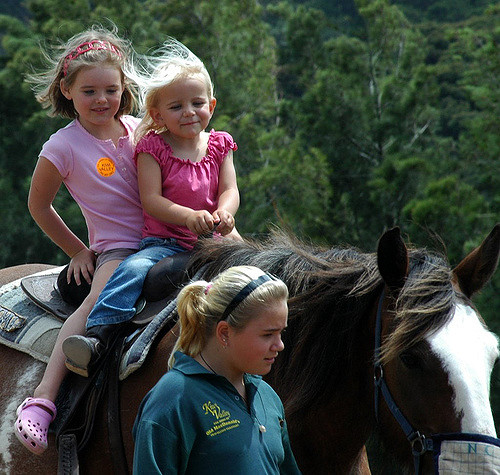

In [23]:
#@title 2. Provide a URL to your image to download
IMAGE_URL = 'https://github.com/tensorflow/models/raw/master/research/deeplab/g3doc/img/image3.jpg' #@param {type:"string"}
!wget -O image {IMAGE_URL}

from PIL import Image
image = Image.open('image')
image

#### Prepare the downloaded image for running inference

(475, 475) (500, 475)


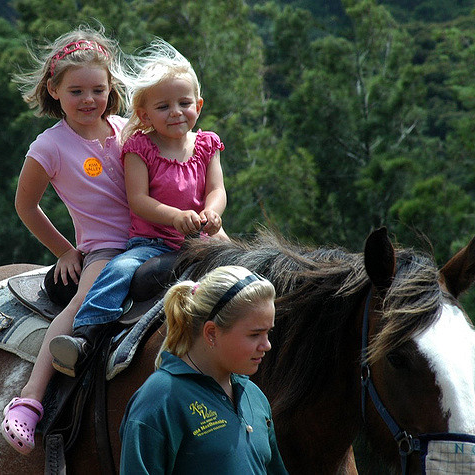

In [24]:
from PIL import ImageOps

old_size = image.size  # old_size is in (width, height) format
desired_ratio = input_size[0] / input_size[1]
old_ratio = old_size[0] / old_size[1]

if old_ratio < desired_ratio: # '<': cropping, '>': padding
    new_size = (old_size[0], int(old_size[0] / desired_ratio))
else:
    new_size = (int(old_size[1] * desired_ratio), old_size[1])

print(new_size, old_size)

# Cropping the original image to the desired aspect ratio
delta_w = new_size[0] - old_size[0]
delta_h = new_size[1] - old_size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
cropped_image = ImageOps.expand(image, padding)
cropped_image

In [25]:
# Resize the cropped image to the desired model size
resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)

# Convert to a NumPy array, add a batch dimension, and normalize the image.
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1

Thanks to Khanh for helping to figure out the pre-processing and post-processing code.

### 3. Run Inference

In [26]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=model_dict[tflite_model_type])

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = cropped_image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

The following code comes from https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. 

In [27]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

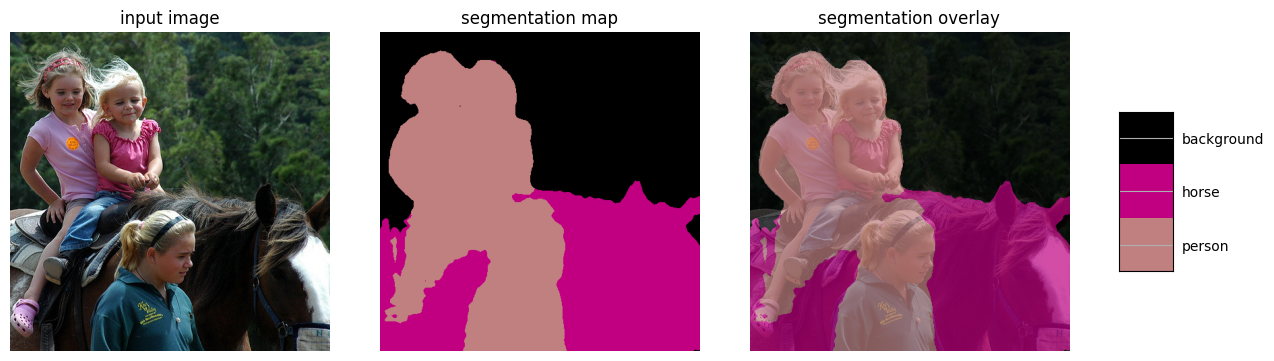

In [28]:
vis_segmentation(cropped_image, seg_map)


To try out a new model it's advisable to Factory Reset the runtime and then trying it.